## Polyfit emulator covariance

I noticed a bug in the calculation of the polyfit emulator uncertainty. At https://github.com/igmhub/LaCE/blob/main/lace/emulator/gp_emulator.py#L351 we have `err=(err[0]*interpolated_P**4+err[1]*interpolated_P**3+err[2]*interpolated_P**2+err[3]*interpolated_P)` which is incorrect. So I'll start by rederiving a more well motivated formula, and test the impact on the end covariances.

For some function $Q(x,y,z)$, if we have uncertainties $\sigma_x$, $\sigma_y$, $\sigma_z$, we can express the uncertainty on $Q$ as:

$$\sigma_Q^2=\sigma_x^2\bigg(\frac{\partial Q}{\partial x}\bigg)^2 + \sigma_y^2\bigg(\frac{\partial Q}{\partial y}\bigg)^2 + \sigma_z^2\bigg(\frac{\partial Q}{\partial z}\bigg)^2$$

Our polyfit emulator models the $P_\mathrm{1D}$ as a polynomial in logspace:

$$y = \log P_\mathrm{1D}= \sum_{n=0}^4 c_n x^n $$
with 
$$x = \log k_\parallel$$

and returns variances on each of these coefficients, $c_n$, i.e. $\sigma_{cn}$. We want to propagate this to an uncertainty on the $P_\mathrm{1D}$. 

$$\frac{\sigma_{P1D}^2}{P_\mathrm{1D}^2}=\sigma_y^2=\sum_{n=0}^4 \big( \sigma_{cn} x^n \big)^2 $$


In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Lace modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace.cosmo import camb_cosmo
from lace.cosmo import fit_linP
from lace_manager.emulator import test_simulation

In [2]:
## Load training set
skewers_label='Ns500_wM0.05'
p1d_label=None
basedir="/lace/emulator/sim_suites/Australia20/"
archive=p1d_archive.archiveP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,nearest_tau=False,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [3]:
emu_type="polyfit"
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                verbose=False,paramList=None,train=True,
                                kmax_Mpc=kmax_Mpc,
                                #rbf_only=True,asymmetric_kernel=True,
                                emu_type=emu_type,passarchive=archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 270 points
GPs optimised in 0.30 seconds


In [4]:
Test_central=test_simulation.TestSimulation(basedir,"central",skewers_label)
Test_training=test_simulation.TestSimulation(basedir,5,skewers_label)

In [5]:
idx=np.where(Test_central.k_Mpc<kmax_Mpc)
k_Mpc=Test_central.k_Mpc[idx[0][1:]]

In [6]:
k_Mpc.shape

(85,)

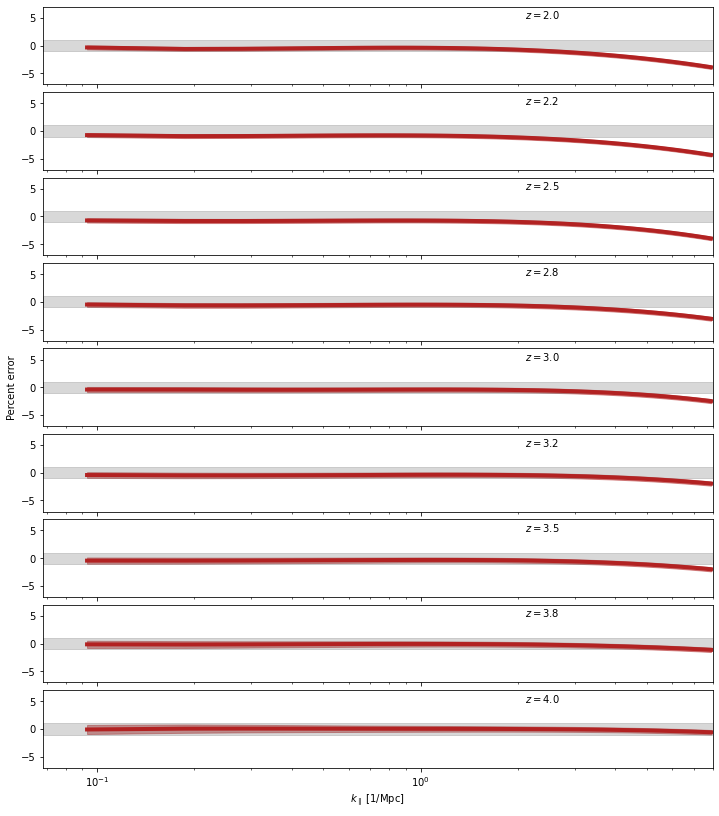

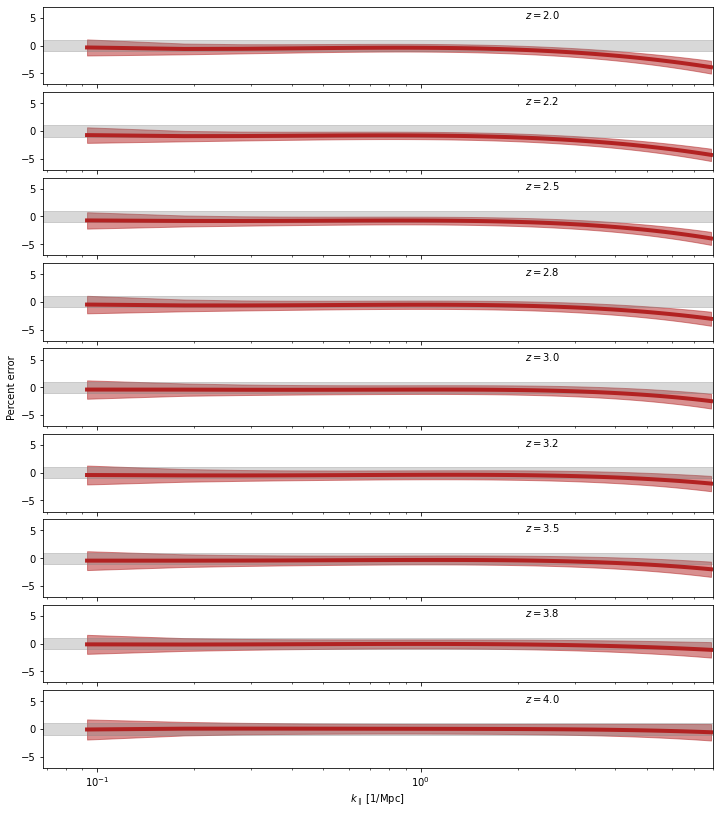

In [7]:
xmin=0.068
xmax=8


plt.figure(figsize=[12,14])
dex=0
for aa in range(0,9,1):
    z=Test_central.zs[aa]
    model=Test_central.get_emulator_calls(z)
    plt.subplot(9,1,(aa+1))
    col = "firebrick"
    
    if emu_type=='k_bin':
        test_k_Mpc,test_pk_Mpc=Test_central.get_p1d_Mpc(z)
    elif emu_type=='polyfit':
        test_k_Mpc,test_pk_Mpc=Test_central.get_polyfit_p1d_Mpc(z=z,fit_kmax_Mpc=kmax_Mpc)
    else:
        raise ValueError 
        
    pk_test=test_pk_Mpc[idx[0][1:]]
    pred,err=emu.emulate_p1d_Mpc(model,k_Mpc,return_covar=True,old_cov=True)
    
    
    plt.plot(k_Mpc,100*((pred/pk_test)-1),color=col,linewidth=4)
    #plt.plot(k_test,100*(mean_error_rbf[aa,:]),color="black")
    #plt.plot(k_test,-100*mean_error_rbf[aa,:],color="black")
    plt.fill_between(k_Mpc,100*((pred+np.sqrt(np.diag(err)))/pk_test-1),
            100*((pred-np.sqrt(np.diag(err)))/pk_test-1),alpha=0.5,color=col)
    plt.axhspan(-1,1,color="gray",alpha=0.3)

    #plt.axhline(0,linestyle="dashed",color="gray")
    plt.ylim(-7,7)
    #plt.legend(loc="lower right")
    ax = plt.gca()
    ax.set_xscale("log")
    plt.xlim(xmin,xmax)
    #ax.tick_params(top=True,right=True)
    
    ax.text(2.1,4.8,r"$z=%.1f$" % Test_central.zs[aa])

    if aa != 8:
        ax.axes.xaxis.set_ticklabels([])
        #ax.axes.yaxis.set_ticklabels([])
    if aa==4:
        plt.ylabel("Percent error")
plt.subplots_adjust(hspace=0.1)
plt.xlabel(r"$k_\parallel$ [1/Mpc]")


plt.figure(figsize=[12,14])
dex=0
for aa in range(0,9,1):
    z=Test_central.zs[aa]
    model=Test_central.get_emulator_calls(z)
    plt.subplot(9,1,(aa+1))
    col = "firebrick"
    
    if emu_type=='k_bin':
        test_k_Mpc,test_pk_Mpc=Test_central.get_p1d_Mpc(z)
    elif emu_type=='polyfit':
        test_k_Mpc,test_pk_Mpc=Test_central.get_polyfit_p1d_Mpc(z=z,fit_kmax_Mpc=kmax_Mpc)
    else:
        raise ValueError 
    
    pk_test=test_pk_Mpc[idx[0][1:]]
    pred,err=emu.emulate_p1d_Mpc(model,k_Mpc,return_covar=True,old_cov=False)
    
    plt.plot(k_Mpc,100*((pred/pk_test)-1),color=col,linewidth=4)
    #plt.plot(k_test,100*(mean_error_rbf[aa,:]),color="black")
    #plt.plot(k_test,-100*mean_error_rbf[aa,:],color="black")
    plt.fill_between(k_Mpc,100*((pred+np.sqrt(np.diag(err)))/pk_test-1),
            100*((pred-np.sqrt(np.diag(err)))/pk_test-1),alpha=0.5,color=col)
    plt.axhspan(-1,1,color="gray",alpha=0.3)

    #plt.axhline(0,linestyle="dashed",color="gray")
    plt.ylim(-7,7)
    #plt.legend(loc="lower right")
    ax = plt.gca()
    ax.set_xscale("log")
    plt.xlim(xmin,xmax)
    #ax.tick_params(top=True,right=True)
    
    ax.text(2.1,4.8,r"$z=%.1f$" % z)

    if aa != 8:
        ax.axes.xaxis.set_ticklabels([])
        #ax.axes.yaxis.set_ticklabels([])
    if aa==4:
        plt.ylabel("Percent error")
plt.subplots_adjust(hspace=0.1)
plt.xlabel(r"$k_\parallel$ [1/Mpc]")
plt.savefig('new_test_1.png')

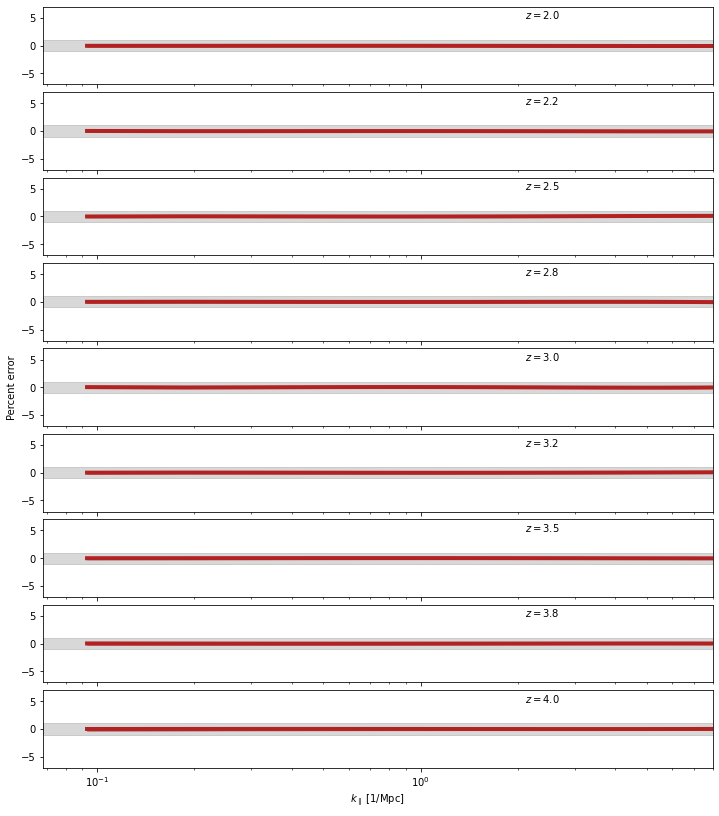

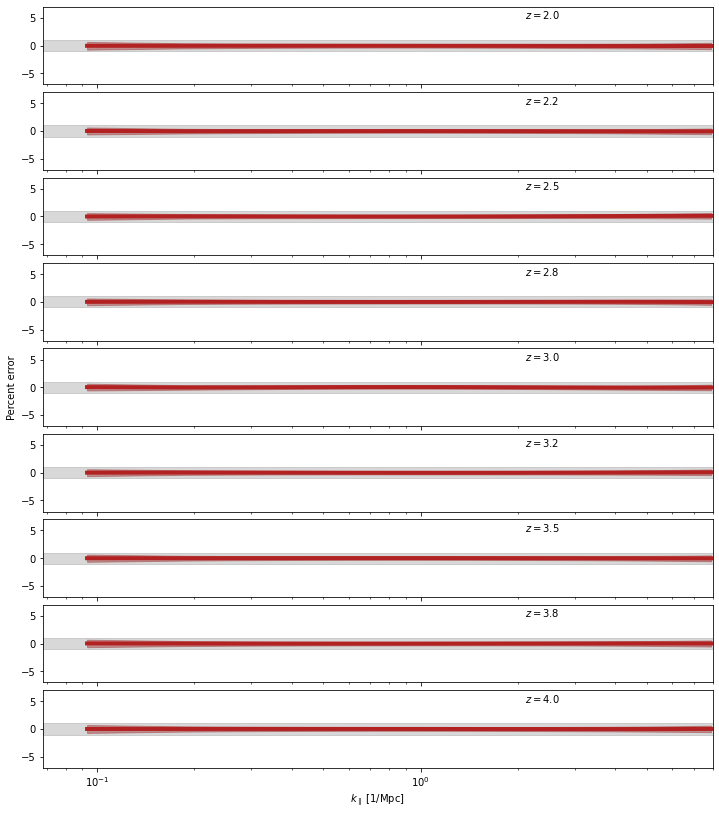

In [8]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,9,1):
    z=Test_training.zs[aa]
    model=Test_training.get_emulator_calls(z)
    plt.subplot(9,1,(aa+1))
    col = "firebrick"
    
    if emu_type=='k_bin':
        test_k_Mpc,test_pk_Mpc=Test_training.get_p1d_Mpc(z)
    elif emu_type=='polyfit':
        test_k_Mpc,test_pk_Mpc=Test_training.get_polyfit_p1d_Mpc(z=z,fit_kmax_Mpc=kmax_Mpc)
    else:
        raise ValueError 
        
    pk_test=test_pk_Mpc[idx[0][1:]]
    pred,err=emu.emulate_p1d_Mpc(model,k_Mpc,return_covar=True,old_cov=True)
    
    
    plt.plot(k_Mpc,100*((pred/pk_test)-1),color=col,linewidth=4)
    #plt.plot(k_test,100*(mean_error_rbf[aa,:]),color="black")
    #plt.plot(k_test,-100*mean_error_rbf[aa,:],color="black")
    plt.fill_between(k_Mpc,100*((pred+np.sqrt(np.diag(err)))/pk_test-1),
            100*((pred-np.sqrt(np.diag(err)))/pk_test-1),alpha=0.5,color=col)
    plt.axhspan(-1,1,color="gray",alpha=0.3)

    #plt.axhline(0,linestyle="dashed",color="gray")
    plt.ylim(-7,7)
    #plt.legend(loc="lower right")
    ax = plt.gca()
    ax.set_xscale("log")
    plt.xlim(xmin,xmax)
    #ax.tick_params(top=True,right=True)
    
    ax.text(2.1,4.8,r"$z=%.1f$" % z)

    if aa != 8:
        ax.axes.xaxis.set_ticklabels([])
        #ax.axes.yaxis.set_ticklabels([])
    if aa==4:
        plt.ylabel("Percent error")
plt.subplots_adjust(hspace=0.1)
plt.xlabel(r"$k_\parallel$ [1/Mpc]")


plt.figure(figsize=[12,14])
dex=0
for aa in range(0,9,1):
    z=Test_training.zs[aa]
    model=Test_training.get_emulator_calls(z)
    plt.subplot(9,1,(aa+1))
    col = "firebrick"
       
    if emu_type=='k_bin':
        test_k_Mpc,test_pk_Mpc=Test_training.get_p1d_Mpc(z)
    elif emu_type=='polyfit':
        test_k_Mpc,test_pk_Mpc=Test_training.get_polyfit_p1d_Mpc(z=z,fit_kmax_Mpc=kmax_Mpc)
    else:
        raise ValueError 
    
    pk_test=test_pk_Mpc[idx[0][1:]]
    pred,err=emu.emulate_p1d_Mpc(model,k_Mpc,return_covar=True,old_cov=False)
    
    
    plt.plot(k_Mpc,100*((pred/pk_test)-1),color=col,linewidth=4)
    #plt.plot(k_test,100*(mean_error_rbf[aa,:]),color="black")
    #plt.plot(k_test,-100*mean_error_rbf[aa,:],color="black")
    plt.fill_between(k_Mpc,100*((pred+np.sqrt(np.diag(err)))/pk_test-1),
            100*((pred-np.sqrt(np.diag(err)))/pk_test-1),alpha=0.5,color=col)
    plt.axhspan(-1,1,color="gray",alpha=0.3)

    #plt.axhline(0,linestyle="dashed",color="gray")
    plt.ylim(-7,7)
    #plt.legend(loc="lower right")
    ax = plt.gca()
    ax.set_xscale("log")
    plt.xlim(xmin,xmax)
    #ax.tick_params(top=True,right=True)
    
    ax.text(2.1,4.8,r"$z=%.1f$" % z)

    if aa != 8:
        ax.axes.xaxis.set_ticklabels([])
        #ax.axes.yaxis.set_ticklabels([])
    if aa==4:
        plt.ylabel("Percent error")
plt.subplots_adjust(hspace=0.1)
plt.xlabel(r"$k_\parallel$ [1/Mpc]")
plt.savefig('new_test_2.png')